In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

from sklearn.ensemble import RandomForestRegressor

## Data Preprocessing

In [5]:
df = pd.read_csv('../Downloads/voter_turnout_merged_all_states.csv')
df.head()

,Residence_Addresses_City,elec_date,elec_year,elec_type,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,voted_voters_asian,...,total_voters_college,total_voters_no_college,voted_voters_college,voted_voters_no_college,perc_turnout_college,perc_turnout_no_college,mean_age,voter_population,voted_voters,state
0,Oakland,2020_11_03,2020,General,30600.0,61476.0,37174.0,8628.0,83122,23041.0,...,80668,27989.0,71356,22543.0,88.456389,80.542356,47.829424,331652,172221,CA
1,Oakland,2018_11_06,2018,General,30600.0,61476.0,37174.0,8628.0,83122,14972.0,...,80668,27989.0,59248,17372.0,73.446720,62.067241,48.224196,331652,130249,CA
2,Oakland,2016_11_08,2016,General,30600.0,61476.0,37174.0,8628.0,83122,16057.0,...,80668,27989.0,60766,18951.0,75.328507,67.708743,46.819512,331652,135633,CA
3,Oakland,2014_11_04,2014,General,30600.0,61476.0,37174.0,8628.0,83122,8145.0,...,80668,27989.0,38216,10811.0,47.374424,38.625889,51.034918,331652,75153,CA
4,San Leandro,2020_11_03,2020,General,12705.0,5596.0,16028.0,2429.0,17780,9229.0,...,19051,10653.0,16014,8674.0,84.058580,81.423073,49.752550,70359,41879,CA


In [6]:
df.columns

Index(['Residence_Addresses_City', 'elec_date', 'elec_year', 'elec_type',
       'total_voters_asian', 'total_voters_black', 'total_voters_hispanic',
       'total_voters_others', 'total_voters_white', 'voted_voters_asian',
       'voted_voters_black', 'voted_voters_hispanic', 'voted_voters_others',
       'voted_voters_white', 'perc_turnout_asian', 'perc_turnout_black',
       'perc_turnout_hispanic', 'perc_turnout_others', 'perc_turnout_white',
       'FECDonors_TotalDonationsAmount', 'FECDonors_NumberOfDonations',
       'mean_donation', 'total_voters_$1000-14999',
       'total_voters_$100000-124999', 'total_voters_$125000-149999',
       'total_voters_$15000-24999', 'total_voters_$150000-174999',
       'total_voters_$175000-199999', 'total_voters_$200000-249999',
       'total_voters_$25000-34999', 'total_voters_$250000+',
       'total_voters_$35000-49999', 'total_voters_$50000-74999',
       'total_voters_$75000-99999', 'voted_voters_$1000-14999',
       'voted_voters_$100000-1

In [7]:
#specify columns to use. Don't want to use data that already has turnout information
use_cols = ['Residence_Addresses_City', 'elec_type',
       'total_voters_asian', 'total_voters_black', 'total_voters_hispanic',
       'total_voters_others', 'total_voters_white',
       'FECDonors_TotalDonationsAmount', 'FECDonors_NumberOfDonations',
       'mean_donation', 'total_voters_$1000-14999',
       'total_voters_$100000-124999', 'total_voters_$125000-149999',
       'total_voters_$15000-24999', 'total_voters_$150000-174999',
       'total_voters_$175000-199999', 'total_voters_$200000-249999',
       'total_voters_$25000-34999', 'total_voters_$250000+',
       'total_voters_$35000-49999', 'total_voters_$50000-74999',
       'total_voters_$75000-99999', 
       'CommercialData_EstimatedHHIncomeAmount', 'total_voters_college',
       'total_voters_no_college', 'mean_age', 'voter_population', 'rcv', 'turnout']

In [8]:
#define RCV and non-rcv cities
rcv_cities = ['Albany', 'Berkeley', 'Eureka', 'Oakland', 'Palm Desert', 'San Francisco', 'San Leandro',
             'Las Cruces', 'Santa Fe', 'Boulder', 'Burlington', 'Portland', 'Takoma Park', 'Bluffdale',
             'Payson', 'Cottonwood Heights', 'Salt Lake City', 'Sandy', 'Midvale', 'Draper', 'Lehi',
             'Springville', 'South Salt Lake', 'Magna', 'Heber', 'Millcreek', 'Riverton', 'St. Louis Park',
             'Bloomington', 'Minneapolis', 'Minnetonka']
non_rcv_cities = list(set(df['Residence_Addresses_City']) - set(rcv_cities))

In [9]:
#function to generate rcv labels
def label_rcv(row):
    if row['Residence_Addresses_City'] in rcv_cities:
        return 1
    else:
        return 0

In [10]:
#add rcv label
df['rcv'] = df.apply(lambda row: label_rcv(row), axis=1)

#add turnout column
df['turnout'] = df['voted_voters'] / df['voter_population']

#filter to usable columns (i.e. columns that do not show turnout)
df = df[use_cols]

#group by city and election type
df = df.groupby(['Residence_Addresses_City', 'elec_type'], as_index=False).mean()
df.drop(columns=['Residence_Addresses_City'], inplace=True)

df.head()

,elec_type,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,FECDonors_TotalDonationsAmount,FECDonors_NumberOfDonations,mean_donation,total_voters_$1000-14999,...,total_voters_$35000-49999,total_voters_$50000-74999,total_voters_$75000-99999,CommercialData_EstimatedHHIncomeAmount,total_voters_college,total_voters_no_college,mean_age,voter_population,rcv,turnout
0,General,373.0,2410.0,2149.0,222.0,1462.0,177264.25,2978.00,59.454730,104.0,...,735.0,1438.0,1892.0,92631.54294,2256.0,1211.0,54.184656,12225.0,0.0,0.246299
1,General,227.0,292.0,4632.0,149.0,13767.0,1021160.00,12005.75,85.319570,673.0,...,3147.0,6387.0,3497.0,65781.06411,6591.0,4083.0,57.574886,23998.0,0.0,0.390408
2,Local_or_Municipal,227.0,292.0,4632.0,149.0,13767.0,441979.50,3063.75,149.988926,673.0,...,3147.0,6387.0,3497.0,65781.06411,6591.0,4083.0,61.541445,23998.0,0.0,0.090872
3,Consolidated_General,89.0,14.0,3492.0,57.0,4816.0,148876.25,1583.50,95.690915,443.0,...,1863.0,2595.0,738.0,71591.14161,3277.0,1616.0,56.419342,6810.0,0.0,0.433811
4,General,89.0,14.0,3492.0,57.0,4816.0,185602.25,2083.00,89.296205,443.0,...,1863.0,2595.0,738.0,71591.14161,3277.0,1616.0,51.515875,6810.0,0.0,0.741410


In [11]:
#examine data
df.describe()

,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,FECDonors_TotalDonationsAmount,FECDonors_NumberOfDonations,mean_donation,total_voters_$1000-14999,total_voters_$100000-124999,...,total_voters_$35000-49999,total_voters_$50000-74999,total_voters_$75000-99999,CommercialData_EstimatedHHIncomeAmount,total_voters_college,total_voters_no_college,mean_age,voter_population,rcv,turnout
count,366.000000,356.000000,368.000000,366.000000,369.000000,3.690000e+02,369.000000,366.000000,361.000000,368.000000,...,367.000000,368.000000,368.000000,369.000000,369.000000,367.000000,369.000000,3.690000e+02,369.000000,369.000000
mean,2950.292350,1093.710674,7812.073370,1318.904372,24903.449864,3.691578e+06,25407.278455,109.803266,696.639889,4766.739130,...,2995.111717,6727.475543,6933.652174,105142.369960,15496.048780,5561.288828,53.586141,4.926078e+04,0.151762,0.387958
std,13234.716553,4699.375816,20873.069312,3569.094920,36106.675742,1.518253e+07,71067.868085,68.007615,1432.363087,8213.898331,...,6570.069225,11862.636194,10879.882636,29123.738326,27061.780591,9489.995134,4.108961,1.024822e+05,0.359277,0.273267
min,1.000000,1.000000,1.000000,1.000000,4.000000,0.000000e+00,0.000000,20.735387,7.000000,1.000000,...,1.000000,1.000000,1.000000,32509.109090,2.000000,4.000000,37.837298,2.722000e+03,0.000000,0.000063
25%,156.250000,19.000000,530.000000,151.000000,8328.000000,2.057788e+05,2651.500000,66.408845,150.000000,971.000000,...,567.000000,1774.000000,2252.000000,85210.521810,4342.000000,1734.500000,50.804998,1.284800e+04,0.000000,0.179470
50%,434.500000,62.000000,1472.500000,365.000000,14635.000000,6.584295e+05,7225.750000,91.560301,331.000000,2390.000000,...,1255.000000,3801.500000,4004.000000,101947.099300,7719.000000,2887.000000,53.349100,2.266000e+04,0.000000,0.374304
75%,1193.750000,345.000000,5067.000000,1061.500000,27225.000000,2.118097e+06,19596.250000,127.739059,653.000000,5350.000000,...,2750.000000,6475.500000,6843.000000,122632.540400,15513.000000,4955.500000,56.570349,4.758300e+04,0.000000,0.515154
max,154854.000000,61476.000000,181747.000000,37173.000000,367189.000000,2.193126e+08,782637.750000,576.172630,10548.000000,94637.000000,...,54626.000000,94290.000000,118544.000000,214958.091500,277172.000000,83021.000000,67.607138,1.088768e+06,1.000000,2.119783


In [12]:
#checking rows with missing values
df[df['total_voters_black'].isnull()]

,elec_type,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,FECDonors_TotalDonationsAmount,FECDonors_NumberOfDonations,mean_donation,total_voters_$1000-14999,...,total_voters_$35000-49999,total_voters_$50000-74999,total_voters_$75000-99999,CommercialData_EstimatedHHIncomeAmount,total_voters_college,total_voters_no_college,mean_age,voter_population,rcv,turnout
40,Consolidated_General,149.0,NaN,352.0,69.0,6629.0,106567.50,930.50,116.653782,52.0,...,104.0,596.0,2096.0,133471.94190,3130.0,1213.0,50.175491,7793.0,1.0,0.187155
41,General,149.0,NaN,352.0,69.0,6629.0,191183.00,1926.25,100.025856,52.0,...,104.0,596.0,2096.0,133471.94190,3130.0,1213.0,45.235569,7793.0,1.0,0.532369
49,Consolidated_General,104.0,NaN,524.0,56.0,8553.0,52464.50,906.75,58.257534,128.0,...,722.0,2859.0,2504.0,85182.42968,4105.0,2120.0,59.260059,13197.0,0.0,0.162272
50,General,104.0,NaN,524.0,56.0,8553.0,131077.25,1858.25,70.516525,128.0,...,722.0,2859.0,2504.0,85182.42968,4105.0,2120.0,53.415146,13197.0,0.0,0.420664
112,General,3.0,NaN,1.0,1.0,79.0,3731.00,51.75,102.184701,NaN,...,5.0,6.0,14.0,112915.25420,54.0,4.0,53.228005,22556.0,0.0,0.002402
113,Local_or_Municipal,3.0,NaN,1.0,1.0,79.0,4308.25,65.75,65.394531,NaN,...,5.0,6.0,14.0,112915.25420,54.0,4.0,56.512640,22556.0,0.0,0.001795
140,Consolidated_General,NaN,NaN,4.0,NaN,49.0,5384.00,82.50,65.260606,NaN,...,1.0,1.0,7.0,110444.44440,17.0,7.0,55.450973,9933.0,1.0,0.001183
141,General,NaN,NaN,4.0,NaN,49.0,11506.50,176.50,65.189908,NaN,...,1.0,1.0,7.0,110444.44440,17.0,7.0,54.332285,9933.0,1.0,0.002844
160,General,1.0,NaN,18.0,1.0,37.0,0.00,0.00,NaN,NaN,...,3.0,19.0,19.0,77780.52830,12.0,13.0,37.837298,23915.0,0.0,0.000836
226,General,NaN,NaN,1.0,1.0,4.0,0.00,0.00,NaN,NaN,...,NaN,1.0,NaN,139125.16670,2.0,NaN,55.435544,39494.0,0.0,0.000063


In [13]:
#dropping rows with incomplete data
df.dropna(inplace=True)
df.describe()

,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,FECDonors_TotalDonationsAmount,FECDonors_NumberOfDonations,mean_donation,total_voters_$1000-14999,total_voters_$100000-124999,...,total_voters_$35000-49999,total_voters_$50000-74999,total_voters_$75000-99999,CommercialData_EstimatedHHIncomeAmount,total_voters_college,total_voters_no_college,mean_age,voter_population,rcv,turnout
count,355.000000,355.000000,355.000000,355.000000,355.000000,3.550000e+02,355.000000,355.000000,355.000000,355.000000,...,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,3.550000e+02,355.000000,355.000000
mean,3040.121127,1096.752113,8064.253521,1358.929577,25797.380282,3.835717e+06,26391.846479,111.085681,703.912676,4929.402817,...,3087.498592,6951.430986,7160.833803,105191.576577,16060.490141,5722.847887,53.601228,5.059086e+04,0.146479,0.398922
std,13428.742525,4705.657785,21207.560229,3616.737216,36519.368504,1.546209e+07,72282.398927,68.496981,1442.974788,8317.858366,...,6660.594903,12017.912660,11009.675268,28696.819689,27436.861876,9606.731976,3.987326,1.042509e+05,0.354085,0.270872
min,22.000000,1.000000,97.000000,22.000000,743.000000,1.520400e+04,332.250000,20.735387,7.000000,40.000000,...,55.000000,231.000000,228.000000,36935.871060,1279.000000,366.000000,40.656594,2.722000e+03,0.000000,0.041955
25%,164.000000,19.500000,653.000000,171.500000,8837.000000,2.278674e+05,2964.625000,67.058099,154.000000,1077.000000,...,607.500000,1924.500000,2344.500000,85337.874080,4714.500000,1821.000000,50.799581,1.340000e+04,0.000000,0.190707
50%,453.000000,62.000000,1562.000000,388.000000,14937.000000,7.069762e+05,7586.750000,92.007802,335.000000,2469.000000,...,1287.000000,3868.000000,4046.000000,101681.373500,8089.000000,2933.000000,53.327358,2.342700e+04,0.000000,0.381577
75%,1257.000000,345.000000,5114.500000,1126.500000,27408.500000,2.211608e+06,20351.125000,129.539313,655.500000,5569.500000,...,2783.500000,6542.000000,6989.000000,122608.815950,15861.000000,5519.500000,56.634865,4.765500e+04,0.000000,0.519995
max,154854.000000,61476.000000,181747.000000,37173.000000,367189.000000,2.193126e+08,782637.750000,576.172630,10548.000000,94637.000000,...,54626.000000,94290.000000,118544.000000,214958.091500,277172.000000,83021.000000,63.042398,1.088768e+06,1.000000,2.119783


In [14]:
#one-hot encode categorical cols
cat_cols = ['elec_type']

df = pd.get_dummies(data=df, columns=cat_cols)
df.head()

,total_voters_asian,total_voters_black,total_voters_hispanic,total_voters_others,total_voters_white,FECDonors_TotalDonationsAmount,FECDonors_NumberOfDonations,mean_donation,total_voters_$1000-14999,total_voters_$100000-124999,...,CommercialData_EstimatedHHIncomeAmount,total_voters_college,total_voters_no_college,mean_age,voter_population,rcv,turnout,elec_type_Consolidated_General,elec_type_General,elec_type_Local_or_Municipal
0,373.0,2410.0,2149.0,222.0,1462.0,177264.25,2978.00,59.454730,104.0,515.0,...,92631.54294,2256.0,1211.0,54.184656,12225.0,0.0,0.246299,0,1,0
1,227.0,292.0,4632.0,149.0,13767.0,1021160.00,12005.75,85.319570,673.0,647.0,...,65781.06411,6591.0,4083.0,57.574886,23998.0,0.0,0.390408,0,1,0
2,227.0,292.0,4632.0,149.0,13767.0,441979.50,3063.75,149.988926,673.0,647.0,...,65781.06411,6591.0,4083.0,61.541445,23998.0,0.0,0.090872,0,0,1
3,89.0,14.0,3492.0,57.0,4816.0,148876.25,1583.50,95.690915,443.0,756.0,...,71591.14161,3277.0,1616.0,56.419342,6810.0,0.0,0.433811,1,0,0
4,89.0,14.0,3492.0,57.0,4816.0,185602.25,2083.00,89.296205,443.0,756.0,...,71591.14161,3277.0,1616.0,51.515875,6810.0,0.0,0.741410,0,1,0


In [15]:
df['rcv'].sum()

52.0

## Model Implementation

In [16]:
#implement random forest
target = df['turnout']
data = df.drop(columns=['turnout'])

rf = RandomForestRegressor()
rf.fit(data, target)
print('Train r_squared: ', rf.score(data, target))

Train r_squared:  0.9457887665443636


In [28]:
#function to generate and print ordered list of feature importance scores
def ordered_feature_importance(features, feature_importances, n=10):
    features = list(features)
    feature_importance = list(feature_importances)
    
    zipped = zip(features, feature_importance)
    sorted_zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
    
    unzipped = list(zip(*sorted_zipped))
    sorted_features = list(unzipped[0])
    sorted_feature_importance = list(unzipped[1])
    
    for i in range(n):
        print('Feature {} ({}) importance: {}'.format(i, sorted_features[i], sorted_feature_importance[i]))
    
    return sorted_features, sorted_feature_importance

In [29]:
sorted_features, sorted_feature_importance = ordered_feature_importance(data.columns, rf.feature_importances_, n=len(data.columns))

Feature 0 (elec_type_General) importance: 0.3644971135011268
Feature 1 (voter_population) importance: 0.12879717841788116
Feature 2 (FECDonors_TotalDonationsAmount) importance: 0.050943801962804194
Feature 3 (total_voters_college) importance: 0.04385230716734223
Feature 4 (FECDonors_NumberOfDonations) importance: 0.035346984499367094
Feature 5 (total_voters_$150000-174999) importance: 0.03463002818178436
Feature 6 (mean_age) importance: 0.03275904374878045
Feature 7 (total_voters_white) importance: 0.03108423870756944
Feature 8 (total_voters_black) importance: 0.027191912852339555
Feature 9 (total_voters_$175000-199999) importance: 0.025652102613414843
Feature 10 (CommercialData_EstimatedHHIncomeAmount) importance: 0.02563377545303072
Feature 11 (total_voters_$100000-124999) importance: 0.024946264107965944
Feature 12 (total_voters_no_college) importance: 0.021562993888098413
Feature 13 (mean_donation) importance: 0.021023020498191144
Feature 14 (total_voters_asian) importance: 0.01883

Text(0.5, 0, 'Ordered feature number')

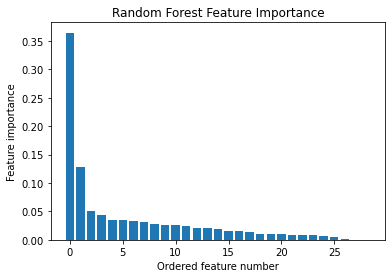

In [32]:
#plot feature importance
plt.bar(np.arange(len(sorted_features)), sorted_feature_importance)
plt.title('Random Forest Feature Importance')
plt.ylabel('Feature importance')
plt.xlabel('Ordered feature number')

### RCV

In [33]:
#implement random forest
rcv_df = df[df['rcv'] == 1]
rcv_target = rcv_df['turnout']
rcv_data = rcv_df.drop(columns=['turnout'])

rcv_rf = RandomForestRegressor()
rcv_rf.fit(rcv_data, rcv_target)
print('Train r_squared: ', rcv_rf.score(rcv_data, rcv_target))

Train r_squared:  0.9593313008151332


In [34]:
#generate and print ordered list of feature importance scores
rcv_sorted_features, rcv_sorted_feature_importance = ordered_feature_importance(rcv_data.columns, rcv_rf.feature_importances_, n=len(rcv_data.columns))

Feature 0 (elec_type_General) importance: 0.6993279109525781
Feature 1 (mean_age) importance: 0.07429865611034693
Feature 2 (CommercialData_EstimatedHHIncomeAmount) importance: 0.030702846771851238
Feature 3 (mean_donation) importance: 0.02491603012214383
Feature 4 (total_voters_$100000-124999) importance: 0.01894341193089543
Feature 5 (FECDonors_TotalDonationsAmount) importance: 0.016495277780735392
Feature 6 (total_voters_$150000-174999) importance: 0.012615048345934523
Feature 7 (total_voters_$250000+) importance: 0.012258765445603087
Feature 8 (total_voters_$175000-199999) importance: 0.011640141752099601
Feature 9 (total_voters_hispanic) importance: 0.01056922778681388
Feature 10 (total_voters_college) importance: 0.010565338678920596
Feature 11 (FECDonors_NumberOfDonations) importance: 0.010292183186465404
Feature 12 (total_voters_$50000-74999) importance: 0.009086500878989651
Feature 13 (elec_type_Consolidated_General) importance: 0.007494497528484146
Feature 14 (total_voters_$1

Text(0.5, 0, 'Ordered feature number')

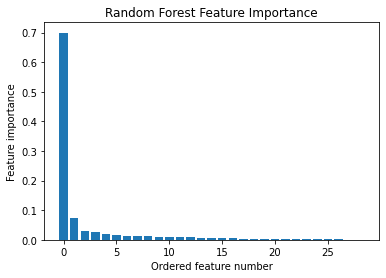

In [35]:
#plot feature importance
plt.bar(np.arange(len(rcv_sorted_features)), rcv_sorted_feature_importance)
plt.title('Random Forest Feature Importance')
plt.ylabel('Feature importance')
plt.xlabel('Ordered feature number')

### Non-RCV

In [36]:
#implement random forest
non_rcv_df = df[df['rcv'] == 0]
non_rcv_target = non_rcv_df['turnout']
non_rcv_data = non_rcv_df.drop(columns=['turnout'])

non_rcv_rf = RandomForestRegressor()
non_rcv_rf.fit(non_rcv_data, non_rcv_target)
print('Train r_squared: ', non_rcv_rf.score(non_rcv_data, non_rcv_target))

Train r_squared:  0.944604800105744


In [37]:
#generate and print ordered list of feature importance scores
non_rcv_sorted_features, non_rcv_sorted_feature_importance = ordered_feature_importance(non_rcv_data.columns, non_rcv_rf.feature_importances_, n=len(non_rcv_data.columns))

Feature 0 (elec_type_General) importance: 0.34873861413005014
Feature 1 (voter_population) importance: 0.12117318255511715
Feature 2 (FECDonors_TotalDonationsAmount) importance: 0.048796844201544044
Feature 3 (total_voters_$175000-199999) importance: 0.04733182252430555
Feature 4 (total_voters_college) importance: 0.04510690334875625
Feature 5 (total_voters_$150000-174999) importance: 0.04480468525179585
Feature 6 (FECDonors_NumberOfDonations) importance: 0.04293039480326638
Feature 7 (total_voters_white) importance: 0.03420999677106952
Feature 8 (CommercialData_EstimatedHHIncomeAmount) importance: 0.02993381272144801
Feature 9 (total_voters_black) importance: 0.0281263321698607
Feature 10 (total_voters_no_college) importance: 0.02365734543903569
Feature 11 (mean_age) importance: 0.021813895124789952
Feature 12 (mean_donation) importance: 0.020220387880958972
Feature 13 (total_voters_asian) importance: 0.018658485884127326
Feature 14 (total_voters_hispanic) importance: 0.01698864276966

Text(0.5, 0, 'Ordered feature number')

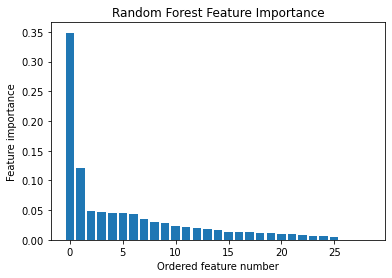

In [38]:
#plot feature importance
plt.bar(np.arange(len(non_rcv_sorted_features)), non_rcv_sorted_feature_importance)
plt.title('Random Forest Feature Importance')
plt.ylabel('Feature importance')
plt.xlabel('Ordered feature number')

### RCV vs. Non-RCV

In [43]:
rcv_v_nonrcv_df = pd.DataFrame({'rcv_feature': rcv_sorted_features, 'rcv_importance': rcv_sorted_feature_importance,
                  'non_rcv_feature': non_rcv_sorted_features, 'non_rcv_importance': non_rcv_sorted_feature_importance})
rcv_v_nonrcv_df.head(20)

,rcv_feature,rcv_importance,non_rcv_feature,non_rcv_importance
0,elec_type_General,0.699328,elec_type_General,0.348739
1,mean_age,0.074299,voter_population,0.121173
2,CommercialData_EstimatedHHIncomeAmount,0.030703,FECDonors_TotalDonationsAmount,0.048797
3,mean_donation,0.024916,total_voters_$175000-199999,0.047332
4,total_voters_$100000-124999,0.018943,total_voters_college,0.045107
5,FECDonors_TotalDonationsAmount,0.016495,total_voters_$150000-174999,0.044805
6,total_voters_$150000-174999,0.012615,FECDonors_NumberOfDonations,0.042930
7,total_voters_$250000+,0.012259,total_voters_white,0.034210
8,total_voters_$175000-199999,0.011640,CommercialData_EstimatedHHIncomeAmount,0.029934
9,total_voters_hispanic,0.010569,total_voters_black,0.028126
